<a href="https://colab.research.google.com/github/ognevlive/ml_clust/blob/master/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Конфигурирование и загрузка данных

In [0]:
#@title ML configuration { run: "auto" }
#@markdown Choose parameters

good_file_count = 800 #@param {type: "number"}
bad_file_count  = 800 #@param {type: "number"}

bad_csv_file   = 'new_bad_trace.csv'  #@param {type: "string"}
good_csv_file  = 'new_good_trace.csv' #@param {type: "string"}

cross_validation_rounds  = 4 #@param {type: "number"}

feature_selection_method  = "chi2" #@param {type: "string"}
feature_selection_count   = 100 #@param {type: "number"}

#@markdown ---


### Загрузка данных


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Flatten, Dropout, Embedding, SimpleRNN, LSTM
from keras.preprocessing import sequence

from random import shuffle
from pprint import pprint
from time import time

X_selection = None
dataset_names = []

def read_data2():
    global X_selection

    X2, y2 = readCSV(bad_csv_file,  1, good_file_count)
    X1, y1 = readCSV(good_csv_file, 0, bad_file_count)
   
    # X = X2
    X = pd.concat((X1, X2), ignore_index=True)
    
    X_selection = X.fillna(0)

    X = X_selection.values
   # y = y2
    y = np.concatenate([y1, y2])

    indexes = np.array(range(len(y)))
    np.random.shuffle(indexes)
    X = X[indexes]
    y = y[indexes]
    
    print X.shape

    print 'Total samples: %d' % len(X)
    print 'Bad   samples: %d' % len(X1)
    print 'Good  samples: %d' % len(X2)
    print ''
    
    return X,y

def readCSV(name, value, limit):
    dataset =pd.read_csv(name, nrows=limit)
    dataset.drop_duplicates(keep=False)
    
    global dataset_names
    if good_csv_file.find('trace') == -1:
        dataset_names += dataset['name'].values.tolist()
        dataset = dataset.drop('name', 1)
    else:
        dataset_names +=  dataset.iloc[:, 0].values.tolist()
        dataset.drop(dataset.columns[0],axis=1,inplace=True)
        
    X = dataset.sample(frac=1)
    
    if   value == 1: y = np.ones((len(X), 1))
    elif value == 0: y = np.zeros((len(X), 1))
        

#     print X
    
#     j = 0
#     for i, x in zip(range(0, len(X[0])), X[0]):
#         if type(x) == type('str'):
#             j = i
#             break
#     X.drop(X.columns[j], axis=1)
        
    return X, y

X, y = read_data2()

Using TensorFlow backend.


(1589, 13563)
Total samples: 1589
Bad   samples: 800
Good  samples: 789



# Кластеризация

## EM

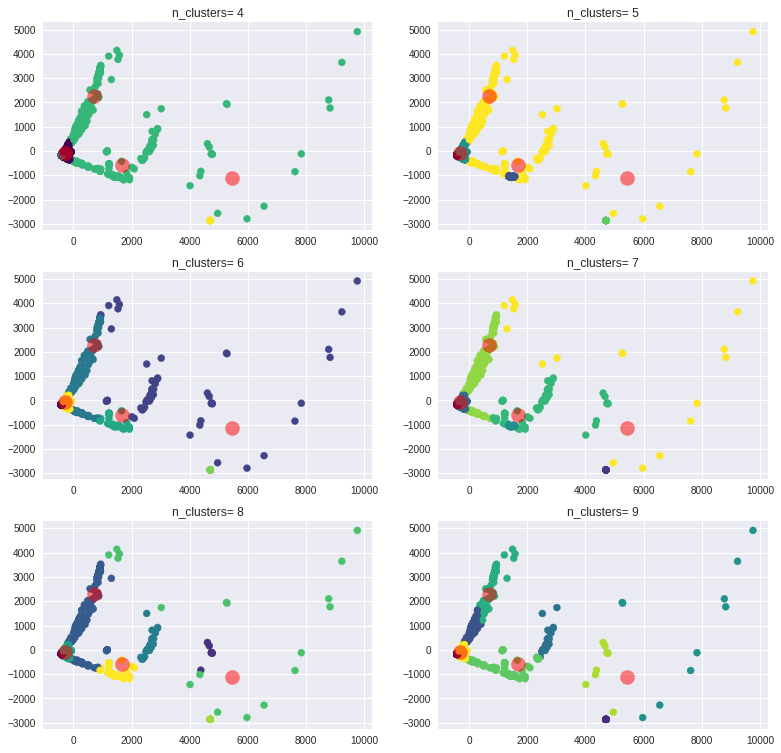

In [0]:
import numpy as np
from sklearn import mixture
np.random.seed(1)


plt.figure(figsize=(13, 13))
for i, k in zip(range(9), range(4, 10)):
    g = mixture.GaussianMixture(covariance_type='diag',n_components=k)

    # Использовать X_pca
    g.fit(X_pca)
    y_kmeans = g.predict(X_pca)

    plt.subplot(3, 2, i + 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
    plt.title('n_clusters= %d' % k)
    


## DBSCAN

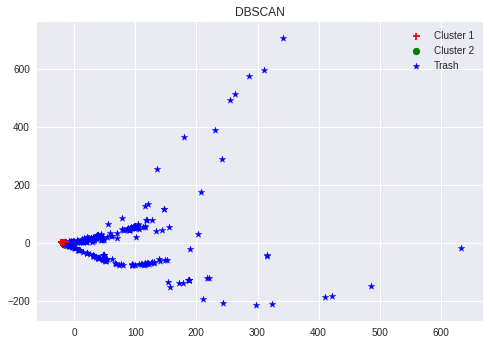

In [0]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

dbscan = DBSCAN()
dbscan.fit(X_pca)

for i in range(0, X_pca.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(X_pca[i, 0], X_pca[i, 1], c='b', marker='*')

plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Trash'])
plt.title('DBSCAN')
plt.show()

## Иерархическая

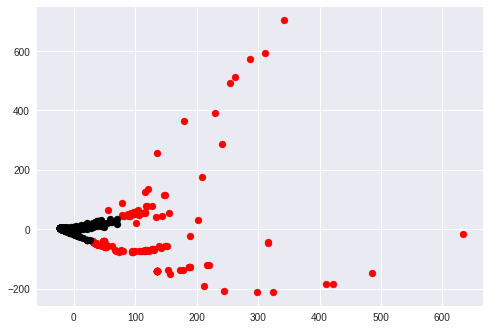

In [0]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

#dendrogram = sch.dendrogram(sch.linkage(X_pca, method='ward'))

hc = AgglomerativeClustering(affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_pca) 

plt.scatter(X_pca[y_hc ==0,0], X_pca[y_hc == 0,1], c='red')
plt.scatter(X_pca[y_hc ==1,0], X_pca[y_hc == 1,1], c='black')
plt.scatter(X_pca[y_hc ==2,0], X_pca[y_hc == 2,1], c='blue')
plt.scatter(X_pca[y_hc ==3,0], X_pca[y_hc == 3,1], c='cyan')
plt.scatter(X_pca[y_hc ==4,0], X_pca[y_hc == 4,1], c='orange')
plt.scatter(X_pca[y_hc ==5,0], X_pca[y_hc == 5,1], c='green')
plt.show()

## AffinityPropagation

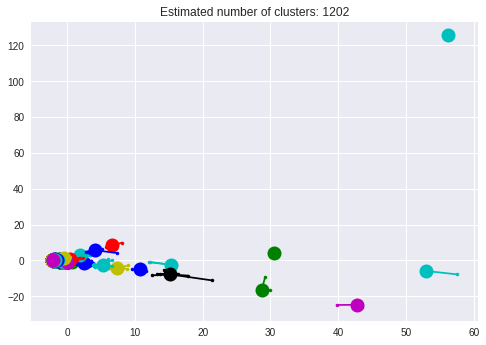

In [0]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle
import matplotlib.pyplot as plt

af = AffinityPropagation(preference=-50).fit(X_pca)

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_pca[cluster_centers_indices[k]]
    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Метод k-средних

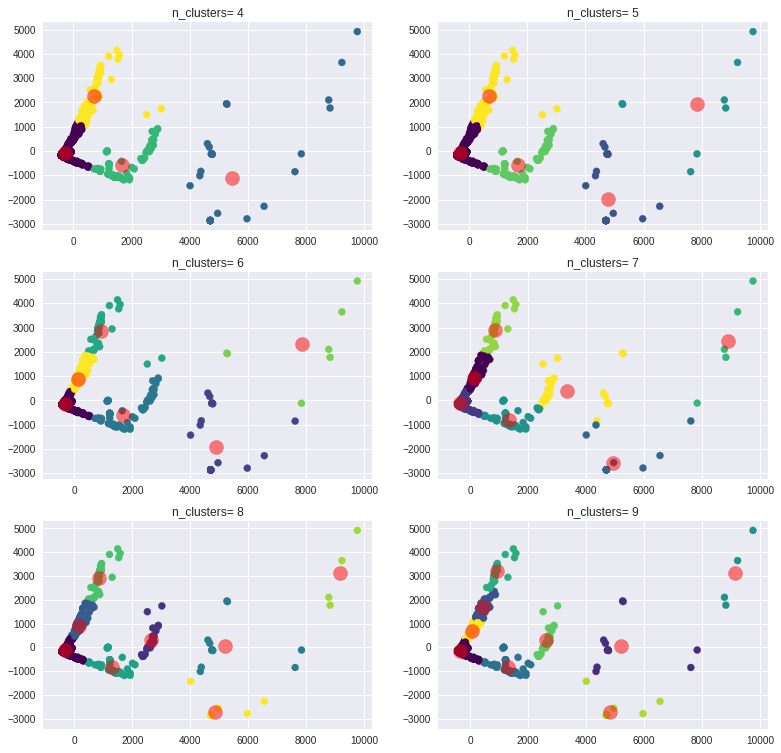

In [0]:
from sklearn.cluster import KMeans

plt.figure(figsize=(13, 13))
for i, k in zip(range(9), range(4, 10)):
    kmeans = KMeans(n_clusters=k)

    # Использовать X_pca
    kmeans.fit(X_pca)
    y_kmeans = kmeans.predict(X_pca)

    plt.subplot(3, 2, i + 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
    
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
    plt.title('n_clusters= %d' % k)

### n_clusters=6

['VirusShare_9a5cb2e862628dd50ca8d4130d8b75fc/VirusShare_9a5cb2e862628dd50ca8d4130d8b75fc.trace', 'VirusShare_305ab6dfe6241377a95d084602f8079a/wuxe.trace', 'VirusShare_d1673e897584fa2ed7c095f8d60099d0/VirusShare_d1673e897584fa2ed7c095f8d60099d0.trace', 'VirusShare_f32bf8d9adb477fe445ab947b6243c73/VirusShare_f32bf8d9adb477fe445ab947b6243c73.trace', 'VirusShare_374009392308a3c753cb808a939726e9/VirusShare_374009392308a3c753cb808a939726e9.trace', 'VirusShare_68650affbc791a395e043fa9400e7535/VirusShare_68650affbc791a395e043fa9400e7535.trace']
['VirusShare_afcc5df0093ef16c5767eccb100ee972/VirusShare_afcc5df0093ef16c5767eccb100ee972.trace', 'VirusShare_e83c81cd3629ee62296a7a01e987697f/VirusShare_e83c81cd3629ee62296a7a01e987697f.trace', 'VirusShare_af55a4768e1cc8849374b3754848ed02/VirusShare_af55a4768e1cc8849374b3754848ed02.trace', 'VirusShare_1af7587dd67005f91981695542fd1bd4/VirusShare_1af7587dd67005f91981695542fd1bd4.trace', 'VirusShare_bae4867f54329bff1709020f9d675435/VirusShare_bae4867f543

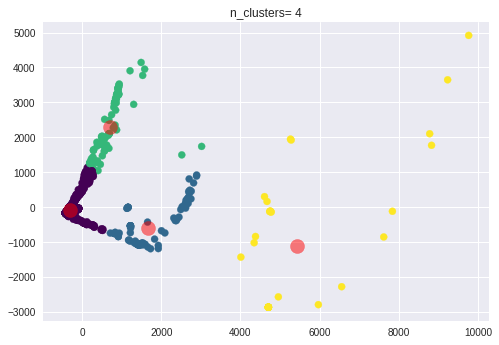

In [0]:
from sklearn.cluster import KMeans
from pprint import pprint

def getNames(X, elements):
    k = len(elements)
    names = [[] for i in range(k)] 

    for i, el in zip(range(k), elements):
        for j in el:
            names[i].append(X[j])
 #       names.append(X[i])
    return names

k = 4
kmeans = KMeans(n_clusters=k)

# Использовать X_pca
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

elements = [[] for i in range(k)] 

for i in range(len(y_kmeans)):
    for j in range(k):        
        if y_kmeans[i] == j:
            elements[j].append(i)

#pprint (elements)

names = getNames(dataset_names, elements)

for i in names:
    print i[:6]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_

plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.title('n_clusters= %d' % k)
plt.show()


### k-means (нахождение оптимального числа классов)

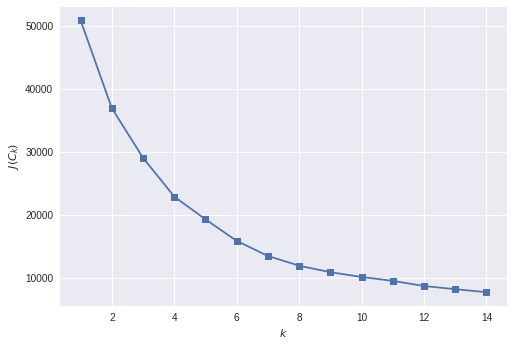

In [0]:
from sklearn.cluster import KMeans

#X_pca = X

inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

## PCA

Explained variance ratio:  [0.31866429 0.16448012]


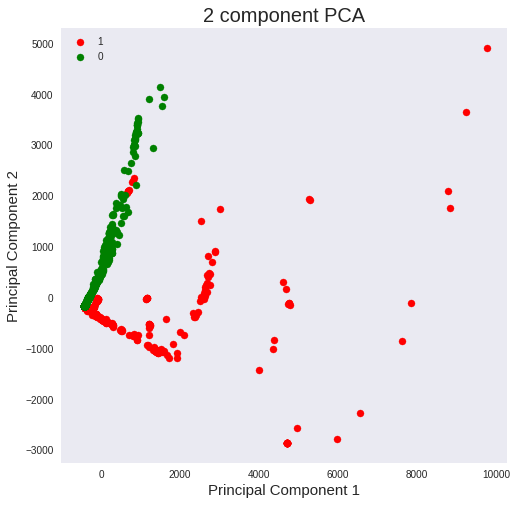

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


X_temp = []
for x in X:
    list = []
    for el in x:
        try:
            len(el)
        except:
            list.append(el)
    X_temp.append(list)
X_temp = np.array(X_temp)

#x = StandardScaler().fit_transform(X_temp)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_temp)
df_pca = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

print 'Explained variance ratio: ', pca.explained_variance_ratio_

df_pca_y = pd.DataFrame({'target' : y[:,0]})
df_pca_final = pd.concat([df_pca, df_pca_y], axis = 1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df_pca_final['target'] == target
    ax.scatter(df_pca_final.loc[indicesToKeep, 'principal component 1'], df_pca_final.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()


X_pca = df_pca_final.iloc[:,0:2].sample(frac=1).values
y_pca = df_pca_final.iloc[:,2].sample(frac=1).values

# Отбор критериев

In [0]:
from sklearn.feature_selection import *

s_mic = SelectKBest(mutual_info_classif, k=feature_selection_count)
s_chi2 = SelectKBest(chi2, k=feature_selection_count)
s_fregr = SelectKBest(f_regression, k=feature_selection_count)

s_mic.fit(X_selection, y)
s_chi2.fit(X_selection, y)
s_fregr.fit(X_selection, y)

# X = 
X = s_mic.transform(X_selection)
s_chi2.transform(X_selection)
s_fregr.transform(X_selection)

attrs_mic   = list(X_selection.columns[s_mic.get_support(indices=True)])
attrs_chi2  = list(X_selection.columns[s_chi2.get_support(indices=True)])
attrs_fregr = list(X_selection.columns[s_fregr.get_support(indices=True)])


mic_chi2 = (list(set(attrs_mic) & set(attrs_chi2)))
mic_fregr = (list(set(attrs_mic) & set(attrs_fregr)))
chi2_freqr = (list(set(attrs_fregr) & set(attrs_chi2)))
mic_chi2_fregr = (list(set(attrs_fregr) & set(attrs_chi2) & set(attrs_mic)))

print 'mic & chi2 (%d):' % len(mic_chi2)
print (mic_chi2)
print ''

print 'mic & fregr (%d):' %  len(mic_fregr)
print (mic_fregr)
print ''

print 'chi2 & fregr (%d):' %  len(chi2_freqr)
print (chi2_freqr)
print ''

print 'mic & chi2 & fregr (%d):' %  len(mic_chi2_fregr)
print (mic_chi2_fregr)
print ''


mic & chi2 (45):
['CreateToolhelp32Snapshot', 'GetAsyncKeyState', 'RegCloseKey', 'OpenServiceA', 'NtSetInformationFile', 'NtCreateKey', 'NtSetValueKey', 'NtQueryValueKey', 'NetGetJoinInformation', 'GetFileAttributesW', 'CryptCreateHash', 'Process32NextW', 'GetSystemMetrics', 'NtQueueApcThread', 'NtReadVirtualMemory', 'SetFileTime', 'SetErrorMode', 'CreateDirectoryW', 'NtWriteFile', 'GetSystemInfo', 'Process32FirstW', 'GetKeyState', 'GetCursorPos', 'NtEnumerateValueKey', 'RegQueryInfoKeyW', 'NtUnmapViewOfSection', 'NtQueryDirectoryFile', 'Module32NextW', 'FindResourceExW', 'NtCreateFile', 'FindFirstFileExW', 'RegQueryInfoKeyA', 'RegEnumValueW', 'GetTempPathW', 'SearchPathW', 'NtOpenKey', 'NtOpenMutant', '__exception__', 'GetFileVersionInfoW', 'FindWindowExW', 'SetEndOfFile', 'NtOpenKeyEx', 'LdrLoadDll', 'OpenSCManagerA', 'NtClose']

mic & fregr (42):
['CreateToolhelp32Snapshot', 'GetAsyncKeyState', 'GetSystemWindowsDirectoryA', 'NetGetJoinInformation', 'OpenServiceA', 'NtQueryMultipleVa

# Алгоритмы машинного обучения

### Случайный лес

In [0]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=80, random_state=17, criterion = 'entropy')
y_pred = cross_val_predict(classifier, X, y, cv=cross_validation_rounds)

### Адаптивный бустинг

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer

#classifier = AdaBoostClassifier(n_estimators=5, learning_rate=15, random_state=17)
classifier = AdaBoostClassifier()
y_pred = cross_val_predict(classifier, X, y, cv=cross_validation_rounds)

### Логистическая регрессия

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer

classifier = LogisticRegression(random_state=17)
y_pred = cross_val_predict(classifier, X, y, cv=cross_validation_rounds)


### Градиентный бустинг

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import fbeta_score, make_scorer

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=17)

##classifier = GradientBoostingClassifier(n_estimators=2, learning_rate = 15, random_state = 0)
classifier = GradientBoostingClassifier()
#classifier.fit(train_X, train_y)
#y_pred = classifier.predict(test_X)
#print confusion_matrix(test_y, y_pred)
y_pred = cross_val_predict(classifier, X, y, cv=cross_validation_rounds)

### Вывод результата

In [0]:
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
total = tn + fp + fn + tp

f1        = cross_val_score(classifier, X, y, cv=cross_validation_rounds, scoring='f1')
accuracy  = cross_val_score(classifier, X, y, cv=cross_validation_rounds, scoring='accuracy')
precision = cross_val_score(classifier, X, y, cv=cross_validation_rounds, scoring='precision')
recall    = cross_val_score(classifier, X, y, cv=cross_validation_rounds, scoring='recall')
roc_auc   = cross_val_score(classifier, X, y, cv=cross_validation_rounds, scoring='roc_auc')


print ('average f1       = %f (+- %f)'   % (f1.mean(), f1.std()))
print ('average acc      = %f (+- %f)'   % (accuracy.mean(), accuracy.std()))
print ('average roc_auc  = %f (+- %f)\n' % (roc_auc.mean(), roc_auc.std()))

print ('average precision = %f (+- %f)'   % (precision.mean(), precision.std()))
print ('average    recall = %f (+- %f)\n' % (recall.mean(), recall.std()))

print ('true positive = %f' % (float(tp) / total * 100))
print ('true negative = %f' % (float(tn) / total * 100))
print ('false positive = %f' % (float(fp) / total * 100))
print ('false negative = %f' % (float(fn) / total * 100))

average f1       = 0.999367 (+- 0.001096)
average acc      = 0.999370 (+- 0.001091)
average roc_auc  = 1.000000 (+- 0.000000)

average precision = 0.998737 (+- 0.002187)
average    recall = 1.000000 (+- 0.000000)

true positive = 49.653870
true negative = 50.283197
false positive = 0.062933
false negative = 0.000000


# Нейронные сети 

### Нейронная сеть

In [0]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=17)

model = Sequential()
model.add(Dense(16, activation='relu', input_dim = X.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                164384    
_________________________________________________________________
dense_25 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_26 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_27 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 165,217
Trainable params: 165,217
Non-trainable params: 0
_________________________________________________________________


### Рекуррентная нейронная сеть

In [0]:
from keras.layers import SimpleRNN

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=17)

model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

### LSTM

In [0]:
from keras.layers import LSTM

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=17)

model = Sequential()
model.add(Embedding(1000, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',   loss='binary_crossentropy',   metrics=['acc']) 

### Вывод результата

In [0]:
from sklearn.metrics import roc_auc_score
%time model.fit(train_X, train_y, epochs = 5, batch_size=128, verbose=True)
%time predict = model.predict(test_X).round()
f1 = f1_score(test_y, predict)
roc_auc = roc_auc_score(test_y, predict)
accuracy = accuracy_score(test_y, predict)

print ('average f1       = %f'   % f1)
print ('average acc      = %f'   % accuracy)
print ('average roc_auc  = %f\n' % roc_auc)

print confusion_matrix(test_y, predict)

#print ('true positive = %f' % (float(tp) / total * 100))
#print ('true negative = %f' % (float(tn) / total * 100))
#print ('false positive = %f' % (float(fp) / total * 100))
#print ('false negative = %f' % (float(fn) / total * 100))

Epoch 1/5
697/697 [==============================] - 28s 40ms/step - loss: 0.6139 - acc: 0.7834
Epoch 2/5
697/697 [==============================] - 27s 39ms/step - loss: 0.4766 - acc: 0.9684
Epoch 3/5
697/697 [==============================] - 27s 39ms/step - loss: 0.3766 - acc: 0.9785
Epoch 4/5
697/697 [==============================] - 28s 39ms/step - loss: 0.3010 - acc: 0.9785
Epoch 5/5
697/697 [==============================] - 27s 39ms/step - loss: 0.2507 - acc: 0.9799
CPU times: user 3min 28s, sys: 13.3 s, total: 3min 41s
Wall time: 2min 18s
CPU times: user 5.82 s, sys: 30.3 ms, total: 5.85 s
Wall time: 5.85 s
average f1       = 0.977778
average acc      = 0.974249
average roc_auc  = 0.970297

[[ 95   6]
 [  0 132]]


### Нахождение оптимального числа эпох

In [0]:
history = model.fit(X, y, epochs=50, verbose=True, validation_split=0.25)
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Построение модели и обучение

In [0]:
def build_model(need_print=False):
    max_features = 1000
    model = Sequential()
    model.add(Embedding(max_features, 32))
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',   loss='binary_crossentropy',   metrics=['acc']) 
 
    if need_print:  
        print model.summary() 

    return model


t = time()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=17)

num_validation_samples = len(X) // cross_validation_rounds
validation_scores = []
print 'Cross-validation:'
print '\ttotal       round = %d' % cross_validation_rounds
print '\tsamples per round = %d' % num_validation_samples
print ''

for fold in range(k):
    test_X = X[num_validation_samples * fold: num_validation_samples * (fold + 1)]
    test_y = y[num_validation_samples * fold: num_validation_samples * (fold + 1)]
    train_X = np.concatenate((X[:num_validation_samples * fold],X[num_validation_samples * (fold + 1):]))
    train_y = np.concatenate((y[:num_validation_samples * fold],y[num_validation_samples * (fold + 1):]))

    x_train, y_train, x_test, y_test = train_X, train_y, test_X, test_y

    
    
    #model = build_model()
    #model = Sequential()
    #model.add(Dense(512, activation='relu'))
    #model.add(Dense(1, activation='sigmoid'))
    #model.compile(optimizer='rmsprop',   loss='binary_crossentropy',   metrics=['acc']) 

    model.fit(x_train, y_train, epochs=25, batch_size=64, verbose=True)
    y_pred = model.predict(x_test).round()
    acc = accuracy_score(y_test, y_pred)
    validation_scores.append(acc)
    print 'round %d: %f' % (fold, acc)

print 'avegare accuracy: %.3f' % np.mean(validation_scores)
print 'time of work: %.3f' % time() - t 


Cross-validation:
	total       round = 4
	samples per round = 232



NameError: ignored

# t-SNE алгоритм

### Подготовка данных для t-SNE алгоритма

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

###Построение 

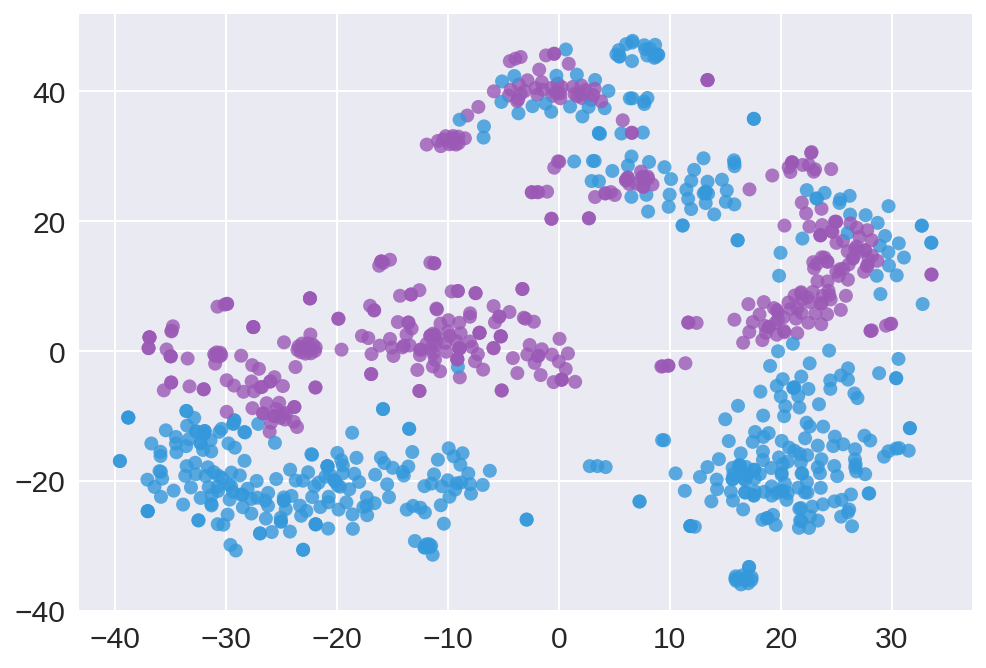

In [0]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt

color = []
for i in range(len(X)):
    if y[i] == 0: color.append("#9b59b6")
    else: color.append("#3498db")
        
sns.regplot(X_2d[:, 0], X_2d[:, 1], scatter_kws={'facecolors':color}, fit_reg=False)

